<a href="https://colab.research.google.com/github/IALeMans/RL-meetup-Reinforcement_Learning/blob/master/RL_GridWorld_QLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jeu GRID WORLD

Source https://cdancette.fr/2017/08/18/reinforcement-learning-part1/

> ![Texte alternatif…](https://cdancette.fr/assets/qlearning2/capture.gif) 

Principe :

![Texte alternatif…](https://cdancette.fr/assets/game.png)

In [0]:
import random


class Game:
    ACTION_UP = 0
    ACTION_LEFT = 1
    ACTION_DOWN = 2
    ACTION_RIGHT = 3

    ACTIONS = [ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT, ACTION_UP]

    ACTION_NAMES = ["UP", "LEFT", "DOWN", "RIGHT"]

    MOVEMENTS = {
        ACTION_UP: (1, 0),
        ACTION_RIGHT: (0, 1),
        ACTION_LEFT: (0, -1),
        ACTION_DOWN: (-1, 0)
    }

    num_actions = len(ACTIONS)

    def __init__(self, n, m, wrong_action_p=0.1, alea=False):
        self.n = n
        self.m = m
        self.wrong_action_p = wrong_action_p
        self.alea = alea
        self.generate_game()



    def _position_to_id(self, x, y):
        """Donne l'identifiant de la position entre 0 et 15"""
        return x + y * self.n

    def _id_to_position(self, id):
        """Réciproque de la fonction précédente"""
        return (id % self.n, id // self.n)

    def generate_game(self):
        cases = [(x, y) for x in range(self.n) for y in range(self.m)]
        hole = random.choice(cases)
        cases.remove(hole)
        start = random.choice(cases)
        cases.remove(start)
        end = random.choice(cases)
        cases.remove(end)
        block = random.choice(cases)
        cases.remove(block)

        self.position = start
        self.end = end
        self.hole = hole
        self.block = block
        self.counter = 0
        
        if not self.alea:
            self.start = start
        return self._get_state()
    
    def reset(self):
        if not self.alea:
            self.position = self.start
            self.counter = 0
            return self._get_state()
        else:
            return self.generate_game()

    def _get_grille(self, x, y):
        grille = [
            [0] * self.n for i in range(self.m)
        ]
        grille[x][y] = 1
        return grille

    def _get_state(self):
        if self.alea:
            return [self._get_grille(x, y) for (x, y) in
                    [self.position, self.end, self.hole, self.block]]
        return self._position_to_id(*self.position)

    def move(self, action):
        """
        takes an action parameter
        :param action : the id of an action
        :return ((state_id, end, hole, block), reward, is_final, actions)
        """
        
        self.counter += 1

        if action not in self.ACTIONS:
            raise Exception("Invalid action")

        # random actions sometimes (2 times over 10 default)
        choice = random.random()
        if choice < self.wrong_action_p:
            action = (action + 1) % 4
        elif choice < 2 * self.wrong_action_p:
            action = (action - 1) % 4

        d_x, d_y = self.MOVEMENTS[action]
        x, y = self.position
        new_x, new_y = x + d_x, y + d_y

        if self.block == (new_x, new_y):
            return self._get_state(), -1, False, self.ACTIONS
        elif self.hole == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), -10, True, None
        elif self.end == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), 10, True, self.ACTIONS
        elif new_x >= self.n or new_y >= self.m or new_x < 0 or new_y < 0:
            return self._get_state(), -1, False, self.ACTIONS
        elif self.counter > 190:
            self.position = new_x, new_y
            return self._get_state(), -10, True, self.ACTIONS
        else:
            self.position = new_x, new_y
            return self._get_state(), -1, False, self.ACTIONS

    def print(self):
        str = ""
        for i in range(self.n - 1, -1, -1):
            for j in range(self.m):
                if (i, j) == self.position:
                    str += "x"
                elif (i, j) == self.block:
                    str += "¤"
                elif (i, j) == self.hole:
                    str += "o"
                elif (i, j) == self.end:
                    str += "@"
                else:
                    str += "."
            str += "\n"
        print(str)

# entrainement

In [0]:
# q learning with table
import numpy as np

states_n = 16
actions_n = 4
Q = np.zeros([states_n, actions_n])

On définit le nombre d’états (16), et d’actions pour chaque état (4). Et on construit le tableau de valeur etat / action Q, rempli de 0.

In [0]:
# Set learning parameters
lr = .85
y = .99
num_episodes = 1000

On définit les paramètres de l’apprentissage.

**lr ** : learning rate, c’est la vitesse d’apprentissage. Plus il est élevé, plus les nouvelles informations seront importantes par rapport aux anciennes. À 0, l’agent n’apprend rien, et à 1, il ne retiendra pas les anciennes infos qu’il a apprises. C’est l’idéal si l’environnement est déterministe (ie 1 etat + 1 action = toujours le même état et la même récompense). Ici l’environnement n’est pas déterministe, car l’agent peut se tromper de direction. On le place donc à .85 (valeur trouvée par tatonnement).

**y** : facteur d’actualisation (gamma), entre 0 et 1. : détermine l’importance des récompenses futures. Trop élevé (trop proche de 1), il y a risque de divergence.

**num_episodes** : le nombre de parties que l’on va faire. 1000 est largement suffisant ici, comme on peut le voir dans les graphiques plus bas.


In [0]:
cumul_reward_list = []
actions_list = []
states_list = []
game = Game(4, 4, 0) # 0.1 chance to go left or right instead of asked direction
for i in range(num_episodes):
    actions = []
    s = game.reset()
    states = [s]
    cumul_reward = 0
    d = False
    while True:
        # on choisit une action aléatoire avec une certaine probabilité, qui décroit
        # TODO : simplifier ça (pas clair)
        Q2 = Q[s,:] + np.random.randn(1, actions_n)*(1. / (i +1))
        a = np.argmax(Q2)
        s1, reward, d, _ = game.move(a)
        Q[s, a] = Q[s, a] + lr*(reward + y * np.max(Q[s1,:]) - Q[s, a]) # Fonction de mise à jour de la Q-table
        cumul_reward += reward
        s = s1
        actions.append(a)
        states.append(s)
        if d == True:
            break
    states_list.append(states)
    actions_list.append(actions)
    cumul_reward_list.append(cumul_reward)

print("Score over time: " +  str(sum(cumul_reward_list[-100:])/100.0))

game.reset()
game.print()

Score over time: 5.0
..ox
....
..¤.
@...



## Explications lignes par lignes

```
    actions = []
    s = game.reset()
    states = [s]
    cumul_reward = 0
    d = False
```
Initialisation du jeu


```
    Q2 = Q[s,:] + np.random.randn(1, actions_n)*(1. / (i +1))
    a = np.argmax(Q2)
```

Etape importante : ici, on choisit quelle action on va effectuer pour ce tour. On a une probabilité de faire une action aléatoire (i = 0 au début, donc l’action est forcément aléatoire). Puis cette probabilité décroit au cours du temps.



```
    Q[s, a] = Q[s, a] + lr*(reward + y * np.max(Q[s1,:]) - Q[s, a]) # Fonction de mise à jour de la Q-table
```


On applique la formule du Q-learning.

## la performance


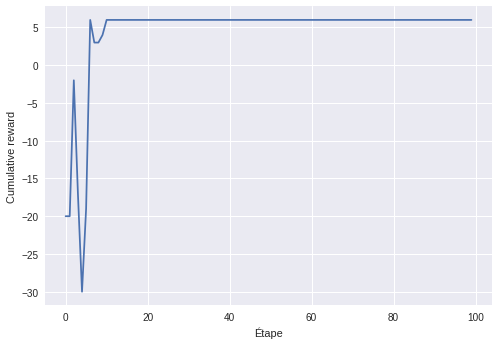

In [0]:
import matplotlib.pyplot as plt
plt.plot(cumul_reward_list[:100])
plt.ylabel('Cumulative reward')
plt.xlabel('Étape')
plt.show()

# démo 

In [0]:
    actions = []
    s = game.reset()
    game.print()
    states = [s]
    cumul_reward = 0
    d = False
    while True:
        # on choisit une action aléatoire avec une certaine probabilité, qui décroit
        # TODO : simplifier ça (pas clair)
        Q2 = Q[s,:] + np.random.randn(1, actions_n)*(1. / (i +1))
        a = np.argmax(Q2)
        s1, reward, d, _ = game.move(a)
        Q[s, a] = Q[s, a] + lr*(reward + y * np.max(Q[s1,:]) - Q[s, a]) # Fonction de mise à jour de la Q-table
        cumul_reward += reward
        s = s1
        actions.append(a)
        states.append(s)
        game.print()
        if d == True:
            break

..@.
..¤.
....
.ox.

..@.
..¤.
..x.
.o..

..@.
..¤.
...x
.o..

..@.
..¤x
....
.o..

..@x
..¤.
....
.o..

..x.
..¤.
....
.o..

